# Analyzing stock data near events with pandas
Stock returns can be heavily impacted by certain events. Sometimes these events are unexpected or a surprise (natural disasters, global pandemics, terrorism) and other times they are scheduled (presidential elections, earnings announcements, financial data releases). We can use pandas to obtain financial data and see the impacts of events the returns of stocks.

In my earlier article on [financial market data analysis with pandas](https://www.wrighters.io/financial-market-data-analysis-with-pandas/), I looked at the basics of obtaining free market data, visualizing the returns of the SPY Exchange Traded Fund, and examined the concept of seasonality, finding some evidence of it in the data. In this article, we'll build on that knowledge to look at daily returns for the stock market and how they are impacted by some major events.

First, let's grab our historical stock data. We'll continue to look at the SPY ETF. Again, SPY is a special type of stock that mirrors the return of the S&P 500. We'll be getting our data from [Alpha Vantage](https://www.alphavantage.co), just like last time. You should get your own API key if you want to follow along on your own since I cannot give you this data.

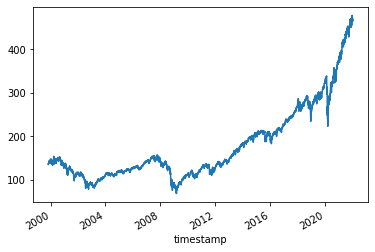

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

try:
    API_KEY = open(os.path.expanduser("~/.alphavantage.key"), 'r').readline().strip()
except Exception as ex:
    print("Put your AlphaVantage API key in the file '.alphavantage.key' in your home directory: ", ex)
    API_KEY = "demo"

def get_daily_bars(symbol):
    function = "TIME_SERIES_DAILY"          # daily data
    outputsize = "full"                     # all of it
    datatype = "csv"                        # CSV - comma separated values
    url = f"https://www.alphavantage.co/query?function={function}&symbol=SPY&outputsize=full&apikey={API_KEY}&datatype={datatype}"
    return pd.read_csv(url, parse_dates=['timestamp'], index_col='timestamp').sort_index()

spy_daily = get_daily_bars("SPY")

spy_daily['close'].plot();

One thing to note about this data is that it doesn't include dividends. The data source that includes them is a premium service currently from Alpha Vantage. But for the analysis we will be doing, this won't be a primary concern.

## What impacts stock returns?
Looking at the chart above, most of us would be able to identify a few points on the chart even if we didn't display the date labels on the X-axis. Most notably is the Covid-19 pandemic, but you can probably spot the great financial crisis and other bigger moves like the 2016 election. Items like a global pandemic are not pre-planned, but US presidential elections are.

Are there certain events that we suspect impact the stock returns more than others? Can we look at some of these and determine the size of the impact on stock returns?

## The Fed
I'm going to cheat a bit and just tell you about one event that does tend to have a large impact on the US markets: the Federal Reserve's interest rate announcements. The [Federal Open Market Committee](https://en.wikipedia.org/wiki/History_of_Federal_Open_Market_Committee_actions) meets regularly to discuss and make decisions about interest rates. These can have huge impacts on the economy, and so most financial assets will need to have their prices adjusted to reflect the future outlook based on these decisions. FOMC days can be highly volatile. Let's see if we can find that in the data.

The Wikipedia article linked above has several tables in it that contains information about FOMC decisions. It turns out that pandas has the ability to read an html page and give you back a list of any tables it finds in the html as a `DataFrame` object. Let's see what that looks like.

In [2]:
fomc = pd.read_html("https://en.wikipedia.org/wiki/History_of_Federal_Open_Market_Committee_actions")

print(len(fomc))
fomc[1].head()

5


,Date,Fed. Funds Rate,Discount Rate,Votes,Notes,Unnamed: 5
0,"November 05, 2020",0%–0.25%,0.25%,10-0,Official statement,NaN
1,"September 16, 2020",0%–0.25%,0.25%,8-2,"Kaplan dissented, preferring ""the Committee [t...",NaN
2,"August 27, 2020",0%–0.25%,0.25%,unanimous,"No meeting, but announcement of approval of up...",NaN
3,"July 29, 2020",0%–0.25%,0.25%,10-0,Official statement,NaN
4,"June 10, 2020",0%–0.25%,0.25%,10-0,Official statement,NaN


It turns out this table is the second table in the page. We can see that for now, we care about the `Date` column. It's currently just text, let's turn it into a data object. You can read more about [pandas data conversion here](https://www.wrighters.io/converting-types-in-pandas/).

In [3]:
fomc_events = fomc[1]
fomc_events['Date'] = pd.to_datetime(fomc_events['Date'])
# we will set the index to be our Data column (explained below)
fomc_events = fomc_events.set_index('Date') # set the Date column as our index
fomc_events.head()

,Fed. Funds Rate,Discount Rate,Votes,Notes,Unnamed: 5
Date,,,,,
2020-11-05,0%–0.25%,0.25%,10-0,Official statement,NaN
2020-09-16,0%–0.25%,0.25%,8-2,"Kaplan dissented, preferring ""the Committee [t...",NaN
2020-08-27,0%–0.25%,0.25%,unanimous,"No meeting, but announcement of approval of up...",NaN
2020-07-29,0%–0.25%,0.25%,10-0,Official statement,NaN
2020-06-10,0%–0.25%,0.25%,10-0,Official statement,NaN


## Finding the impact
OK, now that we have the dates of the events, how do we use it to match up the daily returns for those days? I can tell you from experience that FOMC meetings *tend* to take place on Wednesdays, and the decision and meeting minutes are *usually* released at 14:00 America/New_York, which is during a normal stock trading day. However, some of these events can be emergency meetings that could take place outside of market hours. 

Because of this, we want to be able to look at the impact to the market on the day of the event as well as the next few days. In some cases, the market may take a little bit of time to figure out what the event means and how it will impact prices. We will see if we can quantify this.

One way to do this is to add a column to our returns `DataFrame` that tells us how many days it is past the last FOMC announcements. With that information we can compare returns to see if they are different.

## Merging our data
We have a dense set of dates (the returns) and a sparse set of dates (the FOMC events). We want to find a way to identify all the rows in our returns where an event happens, and then count forward in time until the next event.

There are wany ways to approach this, but here's one way that I've done it in the past. We will first make a column that numbers all of our rows sequentially. Then we'll make a second column where we will store values to subtract from the first to make our final counter. On days when we have an FOMC event, we will set the value to the number for that row, and forward fill those values until the next event. If this sounds confusing, that's fine, we'll walk through each step of the process.

The simplest scenario for this to work is that all of our FOMC events can be found in our returns and we can do this in just a few steps.

In [4]:
spy_daily['days_since_fomc'] = np.arange(len(spy_daily))
spy_daily['FOMC'] = np.nan # initially put in invalid data so we can fill them later

try:
    # set only the rows with a date
    spy_daily.loc[fomc_events.index, 'FOMC'] = spy_daily.loc[fomc_events.index, 'days_since_fomc']
except Exception as ex:
    print(ex)

"[Timestamp('2020-03-15 00:00:00'), Timestamp('2008-03-16 00:00:00')] not in index"


It appears that there are two dates that are not in our daily stock returns. It turns out these were emergency meetings. I can say I definitely remember both of these events. Both of these are Sunday announcements. On March 15, 2020 the FOMC had a second rate cut in response to the global pandemic and made the announcment just minutes before the futures markets opened on Sunday evening. The March 16, 2008 event was due to the collapse of Bear Stearns. I was working at Lehman Brothers at the time, not realizing we had some excitement coming our way as well. Because the stock markets were not open these two days, we cannot set their times to 0. So how can we handle this?

One way is to merge our two datasets. If we only wanted to get matching rows from our SPY data and the FOMC table, we could do a simple `DataFrame` merge. To make the merge easier I made sure both `DataFrame`s had the same type of index above, by setting the `Date` column to the index. Note that you don't have to do this, but it makes life easier.

In [5]:
spy_daily.merge(fomc_events, left_index=True, right_index=True).head()[['close', 'days_since_fomc']]

,close,days_since_fomc
2000-02-02,141.0625,64
2000-03-21,149.1875,97
2000-05-16,146.6875,136
2000-06-28,145.5625,166
2000-08-22,150.2500,204


That might look ok, but the problem with a simple merge is it will drop all the data where there isn't a match for the index, so that merge will not include our emergency meetings. This is the default of `merge`, and can be changed by setting the `how` argument. What we want to do is what is called an outer join.  The `merge` method also has a handy `indicator` param that will puts a column in your `DataFrame` telling you whether the resulting rows are from the `left_only`, `right_only`, or `both`. The left and right are the `DataFrames` as you read them in your code from left to right.

In [6]:
spy_merged = spy_daily.merge(fomc_events, left_index=True, right_index=True, how='outer', indicator=True)

We can look at the rows where the `Fed. Funds Rate` is not null using a boolean index. This will be the rows where the FOMC had an event. We will find all the non-null values in the merged dataset (using the syntax `~` to flip the results of `pd.isnull`). You can read more about boolean indexing [here](https://www.wrighters.io/boolean-indexing-in-pandas/).

In [7]:
spy_merged.loc[~pd.isnull(spy_merged['Fed. Funds Rate']), ['close', 'Fed. Funds Rate', '_merge']].head()

,close,Fed. Funds Rate,_merge
2000-02-02,141.0625,5.75%,both
2000-03-21,149.1875,6.00%,both
2000-05-16,146.6875,6.50%,both
2000-06-28,145.5625,6.50%,both
2000-08-22,150.2500,6.50%,both


If we want to see the rows that *only* come from the FOMC table, we can use the `right_only` value in our `_merge` column. These are rows that were *only* in our FOMC table, not in the returns.

In [8]:
spy_merged.loc[spy_merged['_merge'] == 'right_only', ['close', 'Fed. Funds Rate', '_merge']]

,close,Fed. Funds Rate,_merge
2008-03-16,NaN,3.00%,right_only
2020-03-15,NaN,0%–0.25%,right_only


These are the two 'emergency meeting' rows that kicked out of our initial attempt to set all the rows above. You can see that we don't have price data for those dates (since the market wasn't open). So we will set the 'FOMC' column to the row counter for the *next* date on those two dates, and to the row counter *on* that date for all the other dates. The way to find the next row is to first `shift` the `_merged` column by one, then use that column to find the `right_only` rows. Those will be rows for the next trading day.

In [9]:
spy_merged.loc[spy_merged['_merge'].shift() == 'right_only', ['close', 'Fed. Funds Rate', '_merge']]

,close,Fed. Funds Rate,_merge
2008-03-17,128.30,NaN,left_only
2020-03-16,239.85,NaN,left_only


In [10]:
# set the ones we have in both data sets
spy_merged.loc[spy_merged['_merge'] == 'both', 'FOMC'] = spy_merged.loc[spy_merged['_merge'] == 'both', 'days_since_fomc']
# set the two special meetings
spy_merged.loc[spy_merged['_merge'].shift() == 'right_only', 'FOMC'] = spy_merged.loc[spy_merged['_merge'].shift() == 'right_only', 'days_since_fomc']

Now, we can fill in the all the null data with the offset. We use the `ffill` method for this, it will forward fill all the null values with the last observed non-null value. So every time we have an FOMC event, we will be setting the offset from that day until the next event to be the total up to that day.

In [11]:
spy_merged['FOMC'] = spy_merged['FOMC'].ffill()

The last step is to subtract the FOMC offset from the 'days_since_fomc' value. I'll do this as a new column so you can poke around to see what the two look like, but we could do this in place if we wanted to.

In [12]:
spy_merged['days_since_fomc_calced'] = spy_merged['days_since_fomc'] - spy_merged['FOMC']

In [13]:
spy_merged['days_since_fomc_calced'].describe()

count    5525.000000
mean      178.999095
std       270.565997
min         0.000000
25%        14.000000
50%        33.000000
75%       233.000000
max      1128.000000
Name: days_since_fomc_calced, dtype: float64

Now a few things are immediately obvious. First, we didn't trim the stock data to make sure we didn't look at data from *before* our FOMC source had data, and we need to trim it to some reasonable size *after*, since the data source is not fully up-to-date. So let's do that. 

The easiest way is just limit our data using a boolean selection on the index. We'll keep 30 days after the last event in our dataset. (If you wondered why I chose to do a `copy` at the end, read [this](https://www.wrighters.io/views-copies-and-that-annoying-settingwithcopywarning/)).

In [14]:
spy_merged = spy_merged.loc[(spy_merged.index >= fomc_events.index[-1])
               & (spy_merged.index <= fomc_events.index[0] + pd.Timedelta(days=30))].copy()

The data also doesn't look complete since there are some larger gaps between meetings than we would expect. We'll deal with that later by only looking at the immediate data after (or before) the announcements we have.

## FOMC impact
Wow, that was a lot of work, but now we have a dataset that has two pieces of handy information. We have daily SPY prices (which we can calculate returns on), and a column telling us the number of days since the FOMC made a statement. Let's just look at some high level data first and add a `return` column. We don't want to look at price, but the change in price day to day.

In [15]:
spy_merged['return'] = spy_merged['close'].pct_change()

Now, we want to understand how much these FOMC events impact returns and volatility. Before doing that, what do _normal_ volatility and daily returns look like for SPY? For returns, I'll choose here to look at the absolute value, since I'm interested in the size of the return, not the average return. I'm also going to multiply by 10,000 to see this in basis points, so it's easier to read. A basis point is 1/100 of a percent, and is usually used in finance and trading when talking about things like daily returns, since these numbers tend to be small.

In [16]:
spy_merged['return_bps'] = spy_merged['return'] * 10_000
print("Mean return: ", spy_merged['return_bps'].mean())
print("Mean abs return: ", spy_merged['return_bps'].abs().mean())

Mean return:  2.622952572253447
Mean abs return:  81.86473754180587


For our entire dataset, the mean daily return is 2.6 bps, but the mean size of a daily return is 81 bps (some of these will be up, some will be down, but on averge they'll be 2.6 bps up). 

In terms of volatility, we can look at the standard deviation for the entire set, or even look at it by year.

In [17]:
spy_merged['return_bps'].std()

125.28749957149593

This is the standard deviation for the entire data set. We can see this by year as well. You can see some years are much more volatile than others.

In [18]:
spy_merged.groupby(spy_merged.index.year).std()['return_bps']

2000    144.966923
2001    139.365551
2002    166.543256
2003    104.120539
2004     70.723632
2005     65.164303
2006     63.498013
2007     99.968045
2008    259.338830
2009    168.208984
2010    113.180180
2011    144.958668
2012     80.637251
2013     70.117707
2014     71.086169
2015     98.339539
2016     82.738484
2017     42.652961
2018    107.928186
2019     79.060342
2020    218.100669
Name: return_bps, dtype: float64

This can also be annualized by multiplying by the square root of 252. We do this because volatility increases with the square root of time. There are usually 252 trading days a year for stocks, so in one year we'll have 252 samples of daily volatility. I'll use the percentage returns here since we're looking at annualized values.

In [19]:
spy_merged.groupby(spy_merged.index.year).std()['return'] * np.sqrt(252) * 100

2000    23.012786
2001    22.123595
2002    26.437922
2003    16.528623
2004    11.227029
2005    10.344512
2006    10.079997
2007    15.869435
2008    41.168763
2009    26.702348
2010    17.966797
2011    23.011475
2012    12.800767
2013    11.130841
2014    11.284580
2015    15.610918
2016    13.134327
2017     6.770948
2018    17.133068
2019    12.550440
2020    34.622408
Name: return, dtype: float64

Let's circle back to our FOMC data now, and see what volatility and returns look like for the 30 days after an FOMC announcment. This is fairly easy - we just look for all records within 30 days of the event and `groupby` by the number of days.

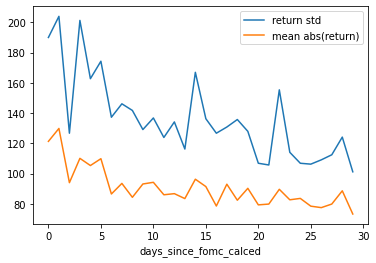

In [20]:
spy_merged_recent = spy_merged.loc[spy_merged['days_since_fomc_calced'] < 30,
                                  ['return_bps', 'days_since_fomc_calced']]

spy_merged_recent.groupby('days_since_fomc_calced').std()['return_bps'].plot(label="return std")
spy_merged_recent.abs().groupby('days_since_fomc_calced').mean()['return_bps'].plot(label="mean abs(return)")
plt.legend();

So looking at the results, we can see the effect of FOMC announcements on the data. Both the standard deviation and size of the returns are highest right around the announcement and then steadily decrease. There's a shock to the system, and then it is absorbed. Can we compare this to the time leading up to the announcement? We can do this by just repeating our earlier process, but doing it backwards.

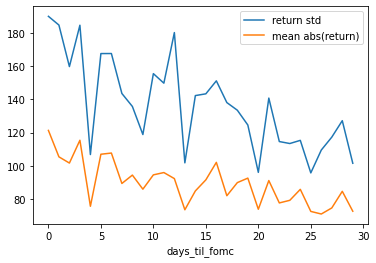

In [21]:
spy_merged['days_til_fomc'] = np.arange(len(spy_merged), 0, -1)
spy_merged['FOMC'] = np.nan  # reset our counter
# use our earlier results to find the FOMC days
spy_merged.loc[spy_merged['days_since_fomc_calced'] == 0, 'FOMC'] = spy_merged.loc[spy_merged['days_since_fomc_calced'] == 0, 'days_til_fomc']
spy_merged['FOMC'] = spy_merged['FOMC'].bfill() # bfill is backwards fill, same logic
spy_merged['days_til_fomc'] -= spy_merged['FOMC'] # we do this in-place instead this time

spy_merged_before = spy_merged.loc[spy_merged['days_til_fomc'] < 30,
                                  ['return_bps', 'days_til_fomc']]

spy_merged_before.groupby('days_til_fomc').std()['return_bps'].plot(label="return std")
spy_merged_before.abs().groupby('days_til_fomc').mean()['return_bps'].plot(label="mean abs(return)")
plt.legend();

Looking at this data we see that day 0 matches our results above (as expected), that's the day of the annoucement. But interestingly the volatility and size of returns does seem to *also* increase leading up to the announcement. This is not exactly what I would have expected. I might have thought that markets would be very quiet as they wait to hear what the Fed is going to do. But I can think of one big reason why markets would not be quiet. If the announcement is an emergency announcement, it's highly likely that the Fed is reacting to extreme market conditions. Those situations would definitely show up in the data leading up to the event.

I'm going to wrap things up for now, but there's a lot more that could be explored here. We could look at other known events and their impact on markets. We could also try to get a higher quality source of FOMC event information since we're obviously missing some data, including some of the more recent announcments. Maybe this exploration will prompt you to dig into market data more.

In terms of pandas usage, we took advantage of the following features:
* loading csv data, including fetching it from a url
* downloading tables from a web page
* `groupby`
* `DataFrame` merging
* boolean indexing
* plotting using matplotlib

Stay tuned for further articles where I will look into other data sources as well as intraday returns.